# F16 Rollrate Compensator

## Setup

First we define how to linearize the aircraft.

In [1]:
import sys
sys.path.insert(0, '..')
import f16
import casadi as ca
import numpy as np
import control
import matplotlib.pyplot as plt


def linearize(x0, u0, p0):
    """
    A function to perform linearizatoin of the f16 model
    @param x0: state
    @param u0: input
    @param p0: parameters
    """
    x0 = x0.to_casadi()
    u0 = u0.to_casadi()# Plot the compensated openloop bode plot

    x_sym = ca.MX.sym('x', x0.shape[0])
    u_sym = ca.MX.sym('u', u0.shape[0])
    x = f16.State.from_casadi(x_sym)
    u = f16.Control.from_casadi(u_sym)
    tables = f16.build_tables()
    dx = f16.dynamics(x, u, p0, tables)
    A = ca.jacobian(dx.to_casadi(), x_sym)
    B = ca.jacobian(dx.to_casadi(), u_sym)
    f_A = ca.Function('A', [x_sym, u_sym], [A])
    f_B = ca.Function('B', [x_sym, u_sym], [B])
    A = f_A(x0, u0)
    B = f_B(x0, u0)
    n = A.shape[0]
    p = B.shape[1]
    C = np.eye(n)
    D = np.zeros((n, p))
    return control.ss(A, B, C, D)

## State and Input Definitions

We now define what the output states and inputs are to make dealing with transfer function easier.

In [2]:
y_id = {
    'VT': 0,
    'alpha': 1,
    'beta': 2,
    'phi': 3,
    'theta': 4,
    'psi': 5,
    'P': 6,
    'Q': 7,
    'R': 8,
    'p_N': 9,
    'p_E': 10,
    'alt': 11,
    'poewr': 12
}

u_id = {
    'thtl': 0,
    'elv_deg': 1,
    'ail_deg': 2,
    'rdr_deg': 3
}

## Linearization of the Model around Steady-Level Flight

We now trim the f16 in steady level flight. For now we are using known values, but this can be written using a function.

In [3]:
p0 = f16.Parameters(xcg=0.38)
x0 = f16.State(VT=502, alpha=0.03544, theta=0.03544)
u0 = f16.Control(thtl=0.1325, elv_deg=-0.0559)
tables = f16.build_tables()
x0.power = tables['tgear'](u0.thtl)
dx = f16.dynamics(x0, u0, p0, tables)
ss = linearize(x0, u0, p0)
G = ss[y_id['P'], u_id['ail_deg']];
G

A = [[-1.87486143e-02  9.37849633e+00  0.00000000e+00  0.00000000e+00
  -3.21700000e+01  0.00000000e+00  0.00000000e+00 -5.30160052e-01
   0.00000000e+00  1.14513182e-06  4.02448855e-01]
 [-2.53991255e-04 -1.01886798e+00  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -0.00000000e+00  9.05195072e-01
  -0.00000000e+00  1.86505025e-06 -2.84238282e-05]
 [ 0.00000000e+00  0.00000000e+00 -3.22013272e-01  6.40434252e-02
   0.00000000e+00  0.00000000e+00  3.48701800e-02  0.00000000e+00
  -9.91736892e-01 -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   3.54548449e-02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  -0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+

## Open Loop

### Root Locus

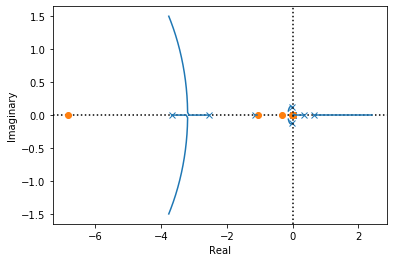

In [4]:
control.rlocus(G, kvect=np.linspace(0, 1e5, 1000));

## Bode plot

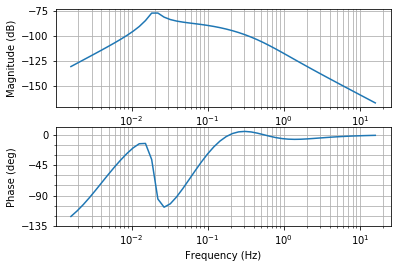

In [5]:
control.bode(G, omega=np.logspace(-2, 2), dB=True, Hz=True);

## Compensator

In [6]:
H = control.ss(0, 0, 0, -1e5)  # simple proportional controller

### Compensated Root Loucs

<Figure size 432x288 with 0 Axes>

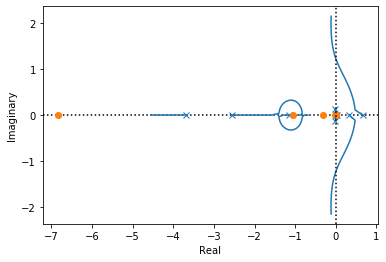

In [7]:
plt.figure()
control.rlocus(G*H, kvect=np.linspace(0, 1));

### Compensated Bode Plot

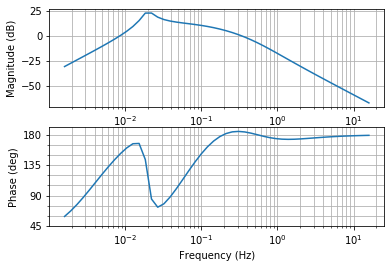

In [8]:
plt.figure()
control.bode(G*H, omega=np.logspace(-2, 2), dB=True, Hz=True);

## Closed Loop

### Bode

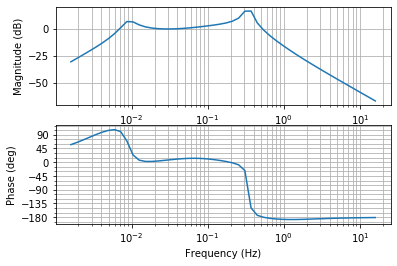

In [9]:
plt.figure()
Gc = control.feedback(G*H, 1)
control.bode(Gc, omega=np.logspace(-2, 2), dB=True, Hz=True);


### Step Response

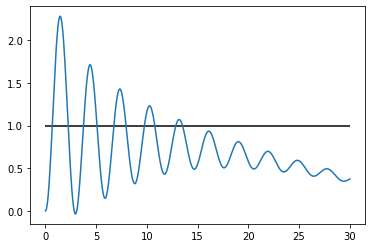

In [10]:
plt.figure()
t, y = control.step_response(Gc, T=np.linspace(0, 30, 1000))
plt.plot(t, y)
plt.hlines(1, 0, 30)